<a href="https://colab.research.google.com/github/pablo14/deeplearning/blob/master/Tutorial_on_SPAM_detection_using_fastai_ULMFiT_Part_1_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on SPAM detection using fastai ULMFiT - Part 1: Language Model

tl;dr: We will walk through the creation of a language model, using a pre-traied network developed by the `fastai` team. Then we will see how known, and unknown word are handled in a way such that the semantic representation of them (embeddings) can be learrnt from the context.

I wrote this post in collaboration with Pablo Zivic, who introduced me in this _deep_ and amazing world of transfer learning. Thanks Z.! 

### The starting point

First we need to install torch and fastai in the google collab session:

In [1]:
# Installing torch_nightly and fastai 
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 25kB/s 


In [0]:
# import libraries

from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

Download SPAM data / TODO: Make  it from original UCI source...

In [0]:
# https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
url='https://raw.githubusercontent.com/pablo14/ulmfit-spam-detector/master/SMSSpamCollection'
df1 = pd.read_csv(url, sep='\t',  header=None, names=['target', 'text'])



In [4]:
df1

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Checking the target distribution


You might question.. what is `ham`? is it eatable?
Google has the answer: 

> "Ham" is e-mail that is not Spam. In other words, "non-spam", or "good mail".





### Split training / test set


Split the data now won't make much sense in this part 1. It will be used in the classification part.

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)



In [6]:
df_trn.head()

,target,text
4853,ham,I liked your new house
2511,ham,Yunny i'm walking in citylink now ü faster com...
4011,spam,Wan2 win a Meet+Greet with Westlife 4 U or a m...
3899,ham,Otherwise had part time job na-tuition..
653,ham,"Wait, do you know if wesleys in town? I bet sh..."


In [7]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Data for the *Language Model* 

In [8]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")



`itos` contains the pairs id-word from our data. The id is the position. This is the **numericalization** step.

Each word is represented with a number (position in the vector).

In [9]:
data_lm.train_ds.vocab.itos[0:30]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'i',
 'to',
 'you',
 ',',
 '?',
 'a',
 'the',
 '!',
 '...',
 'u',
 'and',
 'is',
 'in',
 'my',
 'me',
 'for',
 '..',
 'it',
 'your',
 'do']

Those strange words such as `xxbos`, `xxmaj`, etc -also seen in the `itos` list, are tokens that will the neural network to learn patterns.
Check the full list in the documentation: https://docs.fast.ai/text.transform.html

We can plot the training data for our language model.


In [10]:
data_lm.show_batch()

idx,text
0,"otherwise had part time job na - tuition .. xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs ! xxbos xxmaj so what did the bank say about the money ? xxbos i probably wo n't eat at all today . i think i 'm gon na pop . xxmaj how was your weekend ? xxmaj did u miss me ?"
1,need to write xxbos xxmaj free xxmaj msg : xxunk : http : / / tms . widelive.com / index . xxunk * xxunk = xxunk xxbos i not at home now lei ... xxbos xxmaj can you let me know details of fri when u find out cos i 'm not in tom or fri . xxunk chinese . xxmaj thanks xxbos i know a few people i can
2,"search job : ) xxbos xxmaj where at were hungry too xxbos xxmaj urgent ! call xxunk from xxmaj landline . xxmaj your complimentary 4 * xxmaj tenerife xxmaj holiday or £ 10,000 cash await collection xxup sae t&cs xxup box xxunk xxup xxunk xxup xxunk 150ppm 18 + xxbos xxmaj where @ xxbos 18 days to xxmaj euro2004 xxunk ! u will be kept informed of all the latest"
3,national = rate call . xxbos xxmaj u're welcome ... xxmaj caught u using broken english again ... xxbos xxmaj eek that 's a lot of time especially since xxmaj american xxmaj pie is like 8 minutes long . i ca n't stop singing it . xxbos xxmaj but you dint in touch with me . xxbos xxmaj yes but i do n't care cause i know its there !
4,"even she become quite black .. and ur rite here its too cold , wearing xxunk .. xxbos xxmaj sorry , i 'll call you later . i am in meeting sir . xxbos xxmaj tick , tick , tick ... xxmaj babe xxbos xxmaj yes princess ! i want to please you every night . xxmaj your wish is my xxunk ... xxbos xxmaj i.ll post her out l8r"


### Let's create the language model! 🧙‍♂️✨

Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

In [11]:
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

We've just download the pre-trained model, which is a neural network (NN) with an `AWD_LSTM` architecture.  By setting `pretrained = True` we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).



Basically instead of representing the words as embeddings (one layer) and retrain every time we need create the model, we are using a NN which has the semantic of the words in a context.

You can find more information in: [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146) by Jeremy Howard and Sebastian Ruder 

####  But what is an embedding? 

Just in case you are too new to NLP, we've just talked about a lot of terms and concepts. By now, we are not going to cover it too deeply. Please check the course: https://www.fast.ai/2019/07/08/fastai-nlp/

Each word is a vector, for example:

`hello` is translated into `[0.32, 0.1, 0.5]`. These 3 numbers will be similar to other word that is used in the same context of the text. For example : `hi`. The vector (embedding) for `hi` can be: `[0.30, 0.1, 0.49]`.



_Spending too much reading numbers, will give you the superpower of reading sentences using strange symbols, just like Neo!_

![alt text](https://media.giphy.com/media/Q9aBxHn9fTqKs/giphy.gif)

## Testing the language model

The language model has been created, so now we can test it generating some random sentences (the most simplest _naive deep fake_).

We can test the language by simply call the `predict` function:

In [12]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when smart Mad Men people come down to the
The problem usually starts when we decide to stop over and advance to a friend
The problem usually starts when a single - issue package 's weight is lost ,
The problem usually starts when either one has to concentrate or almost blame their members
The problem usually starts when in the second half of the game , the need


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences! 🤓


### More about the language model

⚠️[Oversimplifying] If sentences makes sense, it's because the training on the wikipedia corpus. Later on, we will adjust a little this model in order to learn the represntations of our particular problem (SPAM detection).

This way, we will save huge amounts of time. Let's say we learn the semantics of English, and then we will adjust it to our particular case.

Medicine and Laws have very different termns, but at the same time, the underlying English structure is the same.

If we make use of the undeerlying structure, and then we learn the particularities of our problem, we are doing something that is called **transfer learning**.

For an overview about Transfer Learning, check: [What is transfer learning? by Nvidia](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/) 


## Inspecting old vs new tokens

Now we are going to download the tokens from the pre-trained model. Remember the `itos` from our data? Well this is the same but using the pre-trained model.




In [0]:
import pickle
with open('/root/.fastai/models/wt103-fwd/itos_wt103.pkl', 'rb') as f:
  orig_itos = pickle.load(f)

  

In [14]:
# Total number of tokens:
len(orig_itos)

60000

Next step will compare the tokens that exists in both dictionaries (pre-trained vs spam data).

And what tokens are not present in the pre-trained.

In [15]:
old_tokens = list(set(data_lm.vocab.itos).intersection(orig_itos))
new_tokens = list(set(data_lm.vocab.itos) - set(orig_itos))

len(old_tokens), len(new_tokens)

(2690, 862)

2690 tokens are present in the pretrained, while 862 aren't.

Some of the new tokens are:

In [16]:
new_tokens[:10]

['goodmorning',
 'minuts',
 'phne',
 'ibh',
 '008704050406',
 '84025',
 '2lands',
 '-message',
 'w45wq',
 'hlp']

It means that there are certain words now on our SPAM data, that were not present in the wipikedia corpus.

The question that arises is, how we are going to handle these new tokens for our model? The absense of these tokens imply that the embedding is initialized randomly.



## Let's play with the data, and learn! 🔎📖

Now, we are going to see the similitudes between two words by comparing their embeddings.

To this end, next functions will help us to normalize the embeddings' weights,  and to return, based on a single token (word), the top 10 most similar tokens.

In [0]:
from torch.nn import functional as F

def get_normalized_embeddings():
  return F.normalize(lang_mod.model[0].encoder.weight)

def most_similar(token, embs):
  idx = data_lm.vocab.itos.index(token)
  sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

  print(f'Similar to: {token}')
  for sim_idx in np.argsort(sims)[::-1][1:11]:
    print(f'{data_lm.vocab.itos[sim_idx]:<30}{sims[sim_idx]:.02f}')

  



### Checking token similarity for old tokens

These tokens should be ok, since the embeddings were learnt based on a big wikipedia corpus...

We will pick some random word, from the old tokens and we will check their similarities. 


_You can play with this by exectuting the cell several times and check what happens!_ 🎮

In [0]:
# Normalizing the embeddings.
embs_v1 = get_normalized_embeddings()

We saved the embeddings so we can improve the network and check the results 😉

In [19]:
from random import choice

old_token = choice(old_tokens) # picking a random word
most_similar(old_token, embs_v1)

Similar to: issues
problems                      0.58
issue                         0.57
difficulties                  0.42
questions                     0.41
problem                       0.38
affairs                       0.34
pages                         0.33
reasons                       0.33
changes                       0.30
decisions                     0.29


For a particular word:

In [20]:
most_similar('nice', embs_v1)

Similar to: nice
lovely                        0.54
cute                          0.52
wonderful                     0.52
funny                         0.50
fantastic                     0.47
pretty                        0.46
stupid                        0.46
horrible                      0.44
weird                         0.44
interesting                   0.43


What we see is the word `nice` is similar to `lovely` (because both are used in similar context, don't you think?)

Now we will do the same, but using the new tokens:

In [21]:
# Random word:
 new_token = choice(new_tokens)
 most_similar(new_token, embs_v1)


Similar to: ranjith
g696ga                        1.00
nurungu                       1.00
minnaminunginte               1.00
11mths                        1.00
aiyah                         1.00
w1                            1.00
08718720201                   1.00
83600                         1.00
bleh                          1.00
ppl                           1.00


We will analyze the word `:)` (yes, the emoji face)

Results will be interesting! 🧙‍♀️

In [22]:
# A particular word:
most_similar(':)', embs_v1)

Similar to: :)
g696ga                        1.00
nurungu                       1.00
minnaminunginte               1.00
11mths                        1.00
aiyah                         1.00
w1                            1.00
08718720201                   1.00
83600                         1.00
bleh                          1.00
ppl                           1.00


We see that:

A) Doesn't make any sense

B) related to A), all the probabilities are 100%... we can see how the embeddings are initiallized randomly. We need to adjust our **Language Model**.

This adjustment is called **fine-tunning**.

### Language Model Fine-Tuning 


![alt text](https://media.giphy.com/media/xMY7fFxaQlyi4/giphy.gif)

Now we will find the best learning rate (LR)

_As the fastai documentation suggests, learn more about the lr_find() at: [ Cyclical Learning Rates for Training Neural Networks](https://)._


Then we will train 4 epochs, using the `fit_one_cycle` function.
This powerful technique will train, by now, only the last layer of our language model.




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01
Min loss divided by 10: 6.31E-02


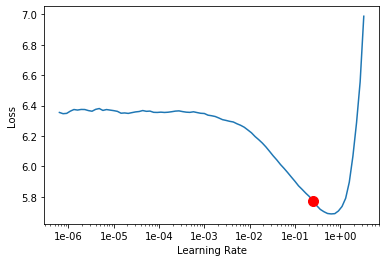

In [23]:
lang_mod.lr_find()
lang_mod.recorder.plot(suggestion=True)



Check how the loss in both train and validation are getting similar:

In [24]:
lang_mod.fit_one_cycle(4, max_lr=2.5E-01)

epoch,train_loss,valid_loss,accuracy,time
0,5.360335,4.139844,0.285714,00:01
1,5.244286,4.462403,0.242857,00:01
2,5.100469,4.185408,0.328571,00:01
3,4.839475,4.103854,0.342857,00:01


We normalize and get the new embeddings for our test:

In [0]:
embs_v2 = get_normalized_embeddings()

In [26]:
most_similar(':)', embs_v2)

#print(lang_mod.predict('xxbos', n_words=20))

Similar to: :)
xxx                           0.36
xxbos                         0.32
?                             0.31
:-(                           0.30
150ppm                        0.27
)                             0.26
...                           0.25
18                            0.25
bslvyl                        0.24
;_;                           0.24


_**And woila!**_ 💥 
Now the word `:)` is related to other words which make perfect sense... they are also emojies!

As a side note, to me it's intersting to see how the emoji face is related to the token `xxbos`. It means something that we can check in practice, some mensages started with the emoji. 

Remeber that `xxbos` is the token for _begin of sentence_.



---




We can continue train the language model, by freezen (if I'm not wrong), only two grorup of layers.

By doing so, we need to have a different LR across the layers, making the impact less agreesive on the deeper layers. Otherwise we could overfit the network and cause the [Catastrophic forgetting](https://en.wikipedia.org/wiki/Catastrophic_interference).

In [0]:
lang_mod.freeze_to(-2)

We need to find the best LR again...

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.45E-02


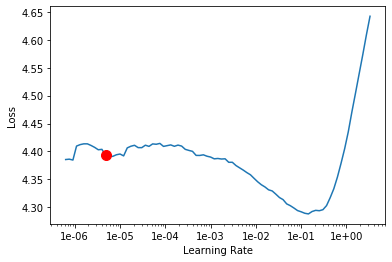

In [28]:
lang_mod.lr_find()
lang_mod.recorder.plot(suggestion=True)

In [29]:
# train the language model
lang_mod.fit_one_cycle(3, slice(1e-2/100, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.334216,4.090609,0.214286,00:01
1,4.189674,4.039083,0.314286,00:01
2,4.083463,3.986425,0.314286,00:01


Higher accuracy and lower (and stable) loss 👌 

### How about checking again the sentences?

In [30]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the problem is one your xxbos Not pain ...
The problem usually starts when you put leave u . Bcoz i 'm in
The problem usually starts when the new year is the only world in xxbos
The problem usually starts when you 're around , pls send my gf that
The problem usually starts when they 're around xxbos So east i left shu


Do you notice any change respect than before?

**Yes**, now the sentences are more related to SMS messages 📲

### Saving the model... 

In [0]:
lang_mod.save('lm_pre_unfreeze')

And that's it! 

That language model will be the one used in our next blog post!

We will create a classification model that, based on a text (SMS), it will assign the probability for SPAM  🕵️‍♂️️📨

### Summing-up! 📝

We went through a process of download a pre-trained **Language Model**, checking the the sentences that it produces, and then we fine-tune this model to tailor the SPAM data semantics.

This process is called: **Transfer Learning**.

We do also check the similitudes across words between a known corpus (based on Wikipedia articles), and how new words representatations (embeddings) can be learnt from the context, in just a few lines of code and time.


### Get in touch!

Found us at:

Pablo Zivic: [Linkedin](https://www.linkedin.com/in/pablozivic) & [twitter](https://twitter.com/ideasrapidas), and me at [linkedin](https://www.linkedin.com/in/pcasas/) & [twitter](https://twitter.com/pabloc_ds) 